<a href="https://colab.research.google.com/github/meidianarahmawati/mlt2hc7/blob/aileen/Disease_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Requirements**


In [1]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

import tensorflow as tf
from tensorflow import keras

In [280]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#**Load Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [174]:
dataset = pd.read_csv('/content/drive/MyDrive/Project DTS/Dataset/dataset.csv')
description = pd.read_csv('/content/drive/MyDrive/Project DTS/Dataset/symptom_Description.csv')
precaution = pd.read_csv('/content/drive/MyDrive/Project DTS/Dataset/symptom_precaution.csv')
severity = pd.read_csv('/content/drive/MyDrive/Project DTS/Dataset/Symptom-severity.csv')

#**EDA**


##Dataset

In [175]:
dataset.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


In [177]:
dataset.shape

(4920, 18)

In [178]:
dataset.describe().transpose()

,count,unique,top,freq
Disease,4920,41,Fungal infection,120
Symptom_1,4920,34,vomiting,822
Symptom_2,4920,48,vomiting,870
Symptom_3,4920,54,fatigue,726
Symptom_4,4572,50,high_fever,378
Symptom_5,3714,38,headache,348
Symptom_6,2934,32,nausea,390
Symptom_7,2268,26,abdominal_pain,264
Symptom_8,1944,21,abdominal_pain,276
Symptom_9,1692,22,yellowing_of_eyes,228


In [179]:
#Menghitung presentase missing values dari masing-masing variabel
(dataset.isnull().sum()/len(dataset)*100).to_frame('Persentase Missing Value Dataset (%)')

,Persentase Missing Value Dataset (%)
Disease,0.000000
Symptom_1,0.000000
Symptom_2,0.000000
Symptom_3,0.000000
Symptom_4,7.073171
Symptom_5,24.512195
Symptom_6,40.365854
Symptom_7,53.902439
Symptom_8,60.487805
Symptom_9,65.609756


In [180]:
dataset['Disease'].unique()

array(['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis',
       'Drug Reaction', 'Peptic ulcer diseae', 'AIDS', 'Diabetes ',
       'Gastroenteritis', 'Bronchial Asthma', 'Hypertension ', 'Migraine',
       'Cervical spondylosis', 'Paralysis (brain hemorrhage)', 'Jaundice',
       'Malaria', 'Chicken pox', 'Dengue', 'Typhoid', 'hepatitis A',
       'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E',
       'Alcoholic hepatitis', 'Tuberculosis', 'Common Cold', 'Pneumonia',
       'Dimorphic hemmorhoids(piles)', 'Heart attack', 'Varicose veins',
       'Hypothyroidism', 'Hyperthyroidism', 'Hypoglycemia',
       'Osteoarthristis', 'Arthritis',
       '(vertigo) Paroymsal  Positional Vertigo', 'Acne',
       'Urinary tract infection', 'Psoriasis', 'Impetigo'], dtype=object)

##Severity

In [181]:
severity.head()

,Symptom,weight
0,itching,1
1,skin_rash,3
2,nodal_skin_eruptions,4
3,continuous_sneezing,4
4,shivering,5


In [182]:
severity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Symptom  133 non-null    object
 1   weight   133 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [183]:
severity.shape

(133, 2)

In [184]:
severity['Symptom'].unique()

array(['itching', 'skin_rash', 'nodal_skin_eruptions',
       'continuous_sneezing', 'shivering', 'chills', 'joint_pain',
       'stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting',
       'vomiting', 'burning_micturition', 'spotting_urination', 'fatigue',
       'weight_gain', 'anxiety', 'cold_hands_and_feets', 'mood_swings',
       'weight_loss', 'restlessness', 'lethargy', 'patches_in_throat',
       'irregular_sugar_level', 'cough', 'high_fever', 'sunken_eyes',
       'breathlessness', 'sweating', 'dehydration', 'indigestion',
       'headache', 'yellowish_skin', 'dark_urine', 'nausea',
       'loss_of_appetite', 'pain_behind_the_eyes', 'back_pain',
       'constipation', 'abdominal_pain', 'diarrhoea', 'mild_fever',
       'yellow_urine', 'yellowing_of_eyes', 'acute_liver_failure',
       'fluid_overload', 'swelling_of_stomach', 'swelled_lymph_nodes',
       'malaise', 'blurred_and_distorted_vision', 'phlegm',
       'throat_irritation', 'redness_of_eyes', 'sinus_pressu

#**Preprocessing**

##General preprocessing

In [185]:
#Menghapus spasi pada kolom symptom dataframe severity dan dataset
severity['Symptom'] = severity['Symptom'].str.replace(' ','')

In [186]:
columns = list(dataset.columns)
columns.remove('Disease')

In [187]:
for col in columns:
    dataset[col] = dataset[col].str.replace(' ', '')

In [188]:
#Menghapus baris yang duplikat pada dataset
#dataset=dataset.drop_duplicates()

In [189]:
dataset.shape

(4920, 18)

In [190]:
#Imputasi missing values dengan 0
dataset = dataset.fillna(0)
dataset.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,itching,nodal_skin_eruptions,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,itching,skin_rash,dischromic_patches,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##Encoding versi 1

In [191]:
#Label encoding pada symptom
symptom_list = list(severity['Symptom'].unique())
le = LabelEncoder()
encoded_symptom = le.fit_transform(symptom_list) 

In [192]:
dictionary={}
for i in range(len(list(le.classes_))):
  dictionary[list(le.classes_)[i]]=i

In [193]:
dictionary

{'abdominal_pain': 0,
 'abnormal_menstruation': 1,
 'acidity': 2,
 'acute_liver_failure': 3,
 'altered_sensorium': 4,
 'anxiety': 5,
 'back_pain': 6,
 'belly_pain': 7,
 'blackheads': 8,
 'bladder_discomfort': 9,
 'blister': 10,
 'blood_in_sputum': 11,
 'bloody_stool': 12,
 'blurred_and_distorted_vision': 13,
 'breathlessness': 14,
 'brittle_nails': 15,
 'bruising': 16,
 'burning_micturition': 17,
 'chest_pain': 18,
 'chills': 19,
 'cold_hands_and_feets': 20,
 'coma': 21,
 'congestion': 22,
 'constipation': 23,
 'continuous_feel_of_urine': 24,
 'continuous_sneezing': 25,
 'cough': 26,
 'cramps': 27,
 'dark_urine': 28,
 'dehydration': 29,
 'depression': 30,
 'diarrhoea': 31,
 'dischromic_patches': 32,
 'distention_of_abdomen': 33,
 'dizziness': 34,
 'drying_and_tingling_lips': 35,
 'enlarged_thyroid': 36,
 'excessive_hunger': 37,
 'extra_marital_contacts': 38,
 'family_history': 39,
 'fast_heart_rate': 40,
 'fatigue': 41,
 'fluid_overload': 42,
 'foul_smell_ofurine': 43,
 'headache': 44,

In [194]:
#Mengganti dataset sesuai label encoding yang dibuat
dataset2 = dataset.replace(dictionary)
dataset2.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,55,101,73,32,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Fungal infection,101,73,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Fungal infection,55,73,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fungal infection,55,101,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fungal infection,55,101,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [195]:
#Label encoding pada disease
disease_list = list(dataset['Disease'].unique())
le = LabelEncoder()
encoded_disease = le.fit_transform(disease_list) 

In [196]:
dictionary_2={}
for i in range(len(list(le.classes_))):
  dictionary_2[list(le.classes_)[i]]=i

In [197]:
dictionary_2

{'(vertigo) Paroymsal  Positional Vertigo': 0,
 'AIDS': 1,
 'Acne': 2,
 'Alcoholic hepatitis': 3,
 'Allergy': 4,
 'Arthritis': 5,
 'Bronchial Asthma': 6,
 'Cervical spondylosis': 7,
 'Chicken pox': 8,
 'Chronic cholestasis': 9,
 'Common Cold': 10,
 'Dengue': 11,
 'Diabetes ': 12,
 'Dimorphic hemmorhoids(piles)': 13,
 'Drug Reaction': 14,
 'Fungal infection': 15,
 'GERD': 16,
 'Gastroenteritis': 17,
 'Heart attack': 18,
 'Hepatitis B': 19,
 'Hepatitis C': 20,
 'Hepatitis D': 21,
 'Hepatitis E': 22,
 'Hypertension ': 23,
 'Hyperthyroidism': 24,
 'Hypoglycemia': 25,
 'Hypothyroidism': 26,
 'Impetigo': 27,
 'Jaundice': 28,
 'Malaria': 29,
 'Migraine': 30,
 'Osteoarthristis': 31,
 'Paralysis (brain hemorrhage)': 32,
 'Peptic ulcer diseae': 33,
 'Pneumonia': 34,
 'Psoriasis': 35,
 'Tuberculosis': 36,
 'Typhoid': 37,
 'Urinary tract infection': 38,
 'Varicose veins': 39,
 'hepatitis A': 40}

In [198]:
#Mengganti dataset sesuai label encoding yang dibuat
dataset2 = dataset2.replace(dictionary_2)
dataset2.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,15,55,101,73,32,0,0,0,0,0,0,0,0,0,0,0,0,0
1,15,101,73,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15,55,73,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,15,55,101,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,55,101,73,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [199]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Disease     4920 non-null   int64
 1   Symptom_1   4920 non-null   int64
 2   Symptom_2   4920 non-null   int64
 3   Symptom_3   4920 non-null   int64
 4   Symptom_4   4920 non-null   int64
 5   Symptom_5   4920 non-null   int64
 6   Symptom_6   4920 non-null   int64
 7   Symptom_7   4920 non-null   int64
 8   Symptom_8   4920 non-null   int64
 9   Symptom_9   4920 non-null   int64
 10  Symptom_10  4920 non-null   int64
 11  Symptom_11  4920 non-null   int64
 12  Symptom_12  4920 non-null   int64
 13  Symptom_13  4920 non-null   int64
 14  Symptom_14  4920 non-null   int64
 15  Symptom_15  4920 non-null   int64
 16  Symptom_16  4920 non-null   int64
 17  Symptom_17  4920 non-null   int64
dtypes: int64(18)
memory usage: 692.0 KB


##Encoding versi 2

In [200]:
symptom_list

['itching',
 'skin_rash',
 'nodal_skin_eruptions',
 'continuous_sneezing',
 'shivering',
 'chills',
 'joint_pain',
 'stomach_pain',
 'acidity',
 'ulcers_on_tongue',
 'muscle_wasting',
 'vomiting',
 'burning_micturition',
 'spotting_urination',
 'fatigue',
 'weight_gain',
 'anxiety',
 'cold_hands_and_feets',
 'mood_swings',
 'weight_loss',
 'restlessness',
 'lethargy',
 'patches_in_throat',
 'irregular_sugar_level',
 'cough',
 'high_fever',
 'sunken_eyes',
 'breathlessness',
 'sweating',
 'dehydration',
 'indigestion',
 'headache',
 'yellowish_skin',
 'dark_urine',
 'nausea',
 'loss_of_appetite',
 'pain_behind_the_eyes',
 'back_pain',
 'constipation',
 'abdominal_pain',
 'diarrhoea',
 'mild_fever',
 'yellow_urine',
 'yellowing_of_eyes',
 'acute_liver_failure',
 'fluid_overload',
 'swelling_of_stomach',
 'swelled_lymph_nodes',
 'malaise',
 'blurred_and_distorted_vision',
 'phlegm',
 'throat_irritation',
 'redness_of_eyes',
 'sinus_pressure',
 'runny_nose',
 'congestion',
 'chest_pain',
 

In [201]:
dataset3 = pd.DataFrame(columns = symptom_list)
dataset3['Disease']=dataset['Disease']

In [202]:
dataset3.shape

(4920, 133)

In [203]:
row,col=dataset.shape
row, col

(4920, 18)

In [210]:
for i in range (row):
  result = np.isin(symptom_list, list(dataset.drop('Disease',axis=1).iloc[i]))
  for j in range(len(result)):
    if result[j]==True:
      dataset3.loc[i,symptom_list[j]]=1

In [211]:
dataset3.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Disease
0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection
1,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection
2,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection
3,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection
4,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fungal infection


In [212]:
dataset3 = dataset3.fillna(0)
dataset3 = dataset3.replace(dictionary_2)
dataset3.head()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Disease
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15


In [213]:
dataset3.shape

(4920, 133)

##Split dataset

In [215]:
#Split dataset menjadi feature (X) dan label (y)
dataset3.astype(int)
y = dataset3['Disease']
X = dataset3.drop(columns=['Disease'])

In [216]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [217]:
X_train.shape

(3936, 132)

In [218]:
y_train.shape

(3936,)

In [266]:
X_train

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
613,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4155,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3803,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3321,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3790,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3264,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1653,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [267]:
y_train

613     19
4155    28
3803    26
3321    15
3790    37
        ..
4859    20
3264    36
1653     4
2607     3
2732    10
Name: Disease, Length: 3936, dtype: int64

#**Build Model**

In [247]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(512,input_shape=[132], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                    tf.keras.layers.Dense(41, activation=tf.nn.softmax)
                                    ])

In [249]:
adam = Adam(learning_rate=0.001)

In [250]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer=adam,metrics=['accuracy'])

In [251]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 512)               68096     
                                                                 
 dense_27 (Dense)            (None, 256)               131328    
                                                                 
 dense_28 (Dense)            (None, 41)                10537     
                                                                 
Total params: 209,961
Trainable params: 209,961
Non-trainable params: 0
_________________________________________________________________


In [252]:
history = model.fit(X_train, y_train, batch_size=64, epochs=50)

Epoch 1/50
62/62 [==============================] - 1s 5ms/step - loss: 3.2470 - accuracy: 0.7810
Epoch 2/50
62/62 [==============================] - 0s 5ms/step - loss: 2.8002 - accuracy: 0.9591
Epoch 3/50
62/62 [==============================] - 0s 5ms/step - loss: 2.7564 - accuracy: 1.0000
Epoch 4/50
62/62 [==============================] - 0s 5ms/step - loss: 2.7552 - accuracy: 1.0000
Epoch 5/50
62/62 [==============================] - 0s 5ms/step - loss: 2.7550 - accuracy: 1.0000
Epoch 6/50
62/62 [==============================] - 0s 5ms/step - loss: 2.7549 - accuracy: 1.0000
Epoch 7/50
62/62 [==============================] - 0s 5ms/step - loss: 2.7548 - accuracy: 1.0000
Epoch 8/50
62/62 [==============================] - 0s 5ms/step - loss: 2.7548 - accuracy: 1.0000
Epoch 9/50
62/62 [==============================] - 0s 5ms/step - loss: 2.7548 - accuracy: 1.0000
Epoch 10/50
62/62 [==============================] - 0s 6ms/step - loss: 2.7547 - accuracy: 1.0000
Epoch 11/50
62/62 [

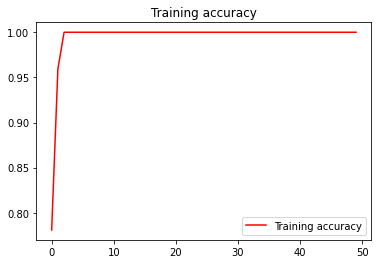

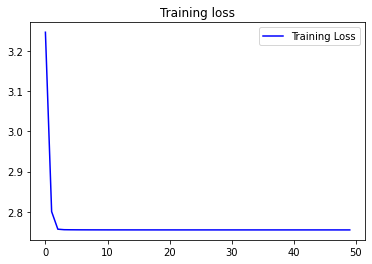

In [253]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#**Testing and Evaluate**

In [234]:
X_test.shape

(984, 132)

In [254]:
test=np.array(X_test.iloc[0])

In [276]:
np.array(X_test.iloc[0]).reshape(1,132)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [269]:
predictions=[]

In [277]:
for i in range(len(X_test)):
  predictions.append(np.argmax(model.predict(np.array(X_test.iloc[i]).reshape(1,132))))

In [ ]:
predictions

In [281]:
testing = pd.DataFrame()
testing['Disease'] = y_test
testing['Pred_Disease'] = predictions

testing

,Disease,Pred_Disease
1525,18,18
1013,40,40
1892,36,36
1972,25,25
873,33,33
...,...,...
3871,11,11
1366,32,32
854,9,9
4224,4,4


In [283]:
print(classification_report(testing['Disease'].values, testing['Pred_Disease'].values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00        31
           3       1.00      1.00      1.00        24
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        21
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00        34
          11       1.00      1.00      1.00        18
          12       1.00      1.00      1.00        22
          13       1.00      1.00      1.00        27
          14       1.00      1.00      1.00        27
          15       1.00      1.00      1.00        24
          16       1.00      1.00      1.00        27
          17       1.00    

#**Simulation for Expert System**

In [284]:
symptom_list

['itching',
 'skin_rash',
 'nodal_skin_eruptions',
 'continuous_sneezing',
 'shivering',
 'chills',
 'joint_pain',
 'stomach_pain',
 'acidity',
 'ulcers_on_tongue',
 'muscle_wasting',
 'vomiting',
 'burning_micturition',
 'spotting_urination',
 'fatigue',
 'weight_gain',
 'anxiety',
 'cold_hands_and_feets',
 'mood_swings',
 'weight_loss',
 'restlessness',
 'lethargy',
 'patches_in_throat',
 'irregular_sugar_level',
 'cough',
 'high_fever',
 'sunken_eyes',
 'breathlessness',
 'sweating',
 'dehydration',
 'indigestion',
 'headache',
 'yellowish_skin',
 'dark_urine',
 'nausea',
 'loss_of_appetite',
 'pain_behind_the_eyes',
 'back_pain',
 'constipation',
 'abdominal_pain',
 'diarrhoea',
 'mild_fever',
 'yellow_urine',
 'yellowing_of_eyes',
 'acute_liver_failure',
 'fluid_overload',
 'swelling_of_stomach',
 'swelled_lymph_nodes',
 'malaise',
 'blurred_and_distorted_vision',
 'phlegm',
 'throat_irritation',
 'redness_of_eyes',
 'sinus_pressure',
 'runny_nose',
 'congestion',
 'chest_pain',
 

In [ ]:
#@title Boolean fields
boolean_checkbox = False #@param {type:"boolean"}
boolean_dropdown = True #@param ["False", "True"] {type:"raw"}
